In [18]:
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np, numpy.random as nr, numpy.linalg as nlg
import scipy.spatial.distance as ssd

import activeSearchInterface as ASI

In [9]:
def polarToCartesian (r, theta):
  return r*np.array([np.cos(theta), np.sin(theta)])

def cartesianToPolar (x, y):
  return np.array([nlg.norm([x,y]), np.arctan(y,x)])

def two_spirals(n=100, loops=2, r=1., h=4, prev=0.5, noise_sigma=0.05,
                shuffle=False):
  """Makes two spirals of a total of n points."""

  npos = int(n * prev)
  nneg = n - npos

  pos_angles = np.linspace(0., 2 * loops * np.pi, npos).reshape(-1, 1)
  pos_range = np.linspace(0., h, npos).reshape(-1, 1)
  pos_pts = np.c_[np.cos(pos_angles), np.sin(pos_angles), pos_range]

  neg_angles = np.linspace(np.pi, (2 * loops + 1) * np.pi, nneg).reshape(-1, 1)
  neg_range = np.linspace(0., h, nneg).reshape(-1, 1)
  neg_pts = np.c_[np.cos(neg_angles), np.sin(neg_angles), neg_range]

  X = np.r_[pos_pts, neg_pts] + nr.randn(n, 3) * np.sqrt(noise_sigma)
  Y = np.array([1] * npos + [0] * nneg)

  if shuffle:
    permutation = nr.permutation(n)
    X = X[permutation]
    Y = Y[permutation]

  return X, Y


def circle_positives(n, r=1, w=0.2, g=0.1, noise_sigma=0.1, shuffle=False):
  """Creates a circle embedded in n^2 points."""
  pvals = np.linspace(-2 * r, 2 * r, n)
  X1, X2 = np.meshgrid(pvals, pvals)
  X = np.stack((X1, X2), axis=2).reshape(-1, 2)

  norm = nlg.norm(X, axis=1)
  Y = ((norm > r - w) & (norm < r + w)).astype(int)
  valid_inds = ~(((norm < r - w) & (norm > r - w - g))
                 | ((norm > r + w) & (norm < r + w + g)))
  
  X = X[valid_inds] + nr.randn(valid_inds.sum(), 2) * np.sqrt(noise_sigma)
  Y = Y[valid_inds]

  if shuffle:
    permutation = nr.permutation(n)
    X = X[permutation]
    Y = Y[permutation]

  return X, Y

def createSwissRolls (npts = 500, prev = 0.5, c = 1.0, nloops = 1.5, var = 0.05, var2 = None, shuffle=False):
  # npts    -- number of points overall
  # prev    -- prevalence of positive class
  # c     -- r = c*theta
  # nloops  -- number of loops of swiss roll
  # var     -- variance of 0-mean gaussian noise along the datapoints
  # shuffle -- shuffle points or keep them grouped as 1/0

  std1 = np.sqrt(var)
  if var2 is None:
    var2 = var
  std2 = np.sqrt(var2)
  n1 = int(prev*npts);
  n2 = npts-n1

  angle_range1 = np.linspace(np.pi/2, 2*nloops*np.pi, n1)
  angle_range2 = np.linspace(np.pi/2, 2*nloops*np.pi, n2)

  X = np.empty([npts,2])
  Y = np.array(n1*[1] + n2*[0])

  for i in xrange(n1):
    a = angle_range1[i]
    X[i,:] = polarToCartesian(a*c, a) + nr.randn(1,2)*std1
  for i in xrange(n2):
    a = angle_range2[i]
    X[i+n1,:] = polarToCartesian(a*c, a+np.pi) + nr.randn(1,2)*std2

  if shuffle:
    shuffle_inds = nr.permutation(npts)
    X = X[shuffle_inds,:]
    Y = Y[shuffle_inds]

  return X,Y


In [6]:
def createEpsilonGraph (X, eps=1, kernel='rbf', gamma=1):
  ## Creates an epsilon graph as follows:
  ## create with edges between points with distance < eps
  ## edge weights are given by kernel
  
  if kernel not in ['rbf']:
    raise NotImplementedError('This function does not support %s kernel.'%kernel)

  dists = ssd.cdist(X,X)
  eps_neighbors = dists < eps

  if kernel == 'rbf':
    A = eps_neighbors*np.exp(-gamma*dists)

  return A

In [468]:
def plotData(X, Y, f=None, labels=None, thresh=None, block=False, fid=None, title=None):

  if fid is not None:
    fig = plt.figure(fid)
  plt.clf()

  if f is None:
    pos_inds = (Y==1).nonzero()[0]
    neg_inds = (Y==0).nonzero()[0]

    plt.scatter(X[pos_inds,0], X[pos_inds,1], color='b', label='positive')
    plt.scatter(X[neg_inds,0], X[neg_inds,1], color='r', label='negative')
    
  else:
    # assert thresh is not None
    assert labels is not None

    pos_inds = (labels==1).nonzero()[0]
    plt.scatter(X[pos_inds,0], X[pos_inds,1], color='b', label='positive', marker='x', linewidth=2)
    neg_inds = (labels==0).nonzero()[0] 
    plt.scatter(X[neg_inds,0], X[neg_inds,1], color='r', label='negative', marker='x', linewidth=2)

    plt.set_cmap('RdBu')
    rest_inds = (labels==-1).nonzero()[0]
    colors = cm.RdBu(f[rest_inds])
    plt.scatter(X[rest_inds,0], X[rest_inds,1], color=colors, label='unlabeled', linewidth=1)

#   plt.legend()
  if fid is not None and title is not None:
    plt.title(title)
  plt.legend()
  plt.show(block=block)
  plt.pause(0.001)
  # time.sleep(0.5)

In [78]:
X, Y = two_spirals(n=1000, prev=0.05, noise_sigma=1, shuffle=False)

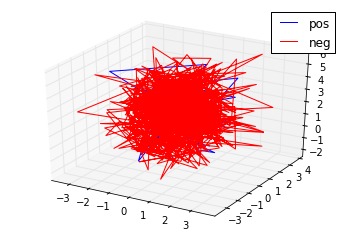

In [79]:
fig = plt.figure()
Xpos = X[Y==1]
Xneg = X[Y==0]
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xpos[:,0], Xpos[:,1], Xpos[:,2], color='b', label='pos')
ax.plot(Xneg[:,0], Xneg[:,1], Xneg[:,2], color='r', label='neg')
plt.legend()
plt.show()

In [65]:
pi = Y.sum() * 1.0 / Y.shape[0]
sparse = False
verbose = True
normalize = True

prms = ASI.Parameters(pi=pi, sparse=sparse, verbose=verbose)
kAS = ASI.linearizedAS(prms)

wnprms = ASI.WNParameters(normalize=normalize, pi=pi, sparse=sparse, verbose=verbose)
wnAS = ASI.weightedNeighborAS(wnprms)


In [66]:
n_init = 1
init_pt = Y.nonzero()[0][np.random.choice(len(Y.nonzero()[0]), n_init, replace=False)]
init_labels = {p:1 for p in init_pt}

In [67]:
kAS.initialize(X.T, init_labels)
wnAS.initialize(X.T, init_labels)

Constructing C
Time for constructing C: 0.000119924545288
Inverting C
Time for inverse: 0.000149965286255
Done with the initialization.
Done with the initialization.


In [68]:
hits1 = [n_init]
hits2 = [n_init]
K = 200
for _ in range(K):
    idx1 = kAS.getNextMessage()
    print('kAS:', idx1, Y[idx1])
    kAS.setLabelCurrent(Y[idx1])
    hits1.append(hits1[-1]+Y[idx1])
    
    idx2 = wnAS.getNextMessage()
    print('wnAS:', idx2, Y[idx2])
    wnAS.setLabelCurrent(Y[idx2])
    hits2.append(hits2[-1]+Y[idx2])

('kAS:', 209, 0)
Iter: 1, Selected: 209, Hits: 1, Time: 0.000194
('wnAS:', 3, 1)
NNAS -- Iter: 1, Selected: 3, Hits: 2, Time: 0.000327
('kAS:', 72, 0)
Iter: 2, Selected: 72, Hits: 1, Time: 0.000164
('wnAS:', 4, 1)
NNAS -- Iter: 2, Selected: 4, Hits: 3, Time: 0.000167
('kAS:', 183, 0)
Iter: 3, Selected: 183, Hits: 1, Time: 0.000121
('wnAS:', 5, 1)
NNAS -- Iter: 3, Selected: 5, Hits: 4, Time: 0.000157
('kAS:', 90, 0)
Iter: 4, Selected: 90, Hits: 1, Time: 0.000120
('wnAS:', 8, 1)
NNAS -- Iter: 4, Selected: 8, Hits: 5, Time: 0.000155
('kAS:', 112, 0)
Iter: 5, Selected: 112, Hits: 1, Time: 0.000116
('wnAS:', 6, 1)
NNAS -- Iter: 5, Selected: 6, Hits: 6, Time: 0.000164
('kAS:', 232, 0)
Iter: 6, Selected: 232, Hits: 1, Time: 0.000118
('wnAS:', 9, 1)
NNAS -- Iter: 6, Selected: 9, Hits: 7, Time: 0.000154
('kAS:', 243, 0)
Iter: 7, Selected: 243, Hits: 1, Time: 0.000132
('wnAS:', 24, 1)
NNAS -- Iter: 7, Selected: 24, Hits: 8, Time: 0.000201
('kAS:', 8, 1)
Iter: 8, Selected: 8, Hits: 2, Time: 0.000

In [80]:
prms = ASI.Parameters(pi=pi, sparse=sparse, verbose=verbose)
sAS = ASI.shariAS(prms)

wnprms = ASI.WNParameters(normalize=normalize, pi=pi, sparse=sparse, verbose=verbose)
wnAS = ASI.weightedNeighborGraphAS(wnprms)

In [81]:
A = createEpsilonGraph(X, eps = np.inf)

In [82]:
sAS.initialize(A, init_labels)
wnAS.initialize(A, init_labels)

Inverting I_A
Time for inverse: 2.61520695686
Done with the initialization.
Done with the initialization.


In [83]:
plotData(X, None, sAS.f, sAS.labels, fid=0)
plotData(X, None, wnAS.f, wnAS.labels, fid=1)

hits1 = [n_init]
hits2 = [n_init]
K = 200
for _ in range(K):
    idx1 = sAS.getNextMessage()
    sAS.setLabelCurrent(Y[idx1])
    hits1.append(hits1[-1]+Y[idx1])
    plotData(X, None, sAS.f, sAS.labels, fid=0)

    idx2 = wnAS.getNextMessage()
    wnAS.setLabelCurrent(Y[idx2])
    hits2.append(hits2[-1]+Y[idx2])
    plotData(X, None, wnAS.f, wnAS.labels, fid=1)

Iter: 1, Selected: 534, Hits: 1, Time: 0.016677
NNAS -- Iter: 1, Selected: 0, Hits: 2, Time: 0.000443
Iter: 2, Selected: 855, Hits: 1, Time: 0.014022
NNAS -- Iter: 2, Selected: 1, Hits: 3, Time: 0.000274
Iter: 3, Selected: 505, Hits: 1, Time: 0.013788
NNAS -- Iter: 3, Selected: 4, Hits: 4, Time: 0.000269
Iter: 4, Selected: 424, Hits: 1, Time: 0.013816
NNAS -- Iter: 4, Selected: 3, Hits: 5, Time: 0.000309
Iter: 5, Selected: 442, Hits: 1, Time: 0.013901
NNAS -- Iter: 5, Selected: 5, Hits: 6, Time: 0.000297
Iter: 6, Selected: 471, Hits: 1, Time: 0.013821
NNAS -- Iter: 6, Selected: 2, Hits: 7, Time: 0.000260
Iter: 7, Selected: 843, Hits: 1, Time: 0.013838
NNAS -- Iter: 7, Selected: 6, Hits: 8, Time: 0.000292
Iter: 8, Selected: 465, Hits: 1, Time: 0.013841
NNAS -- Iter: 8, Selected: 8, Hits: 9, Time: 0.000262
Iter: 9, Selected: 856, Hits: 1, Time: 0.014003
NNAS -- Iter: 9, Selected: 7, Hits: 10, Time: 0.000267
Iter: 10, Selected: 525, Hits: 1, Time: 0.013841
NNAS -- Iter: 10, Selected: 9, H

In [134]:
X, Y = circle_positives(50, r=1, w=0.1, g=0.1, noise_sigma=0.01)

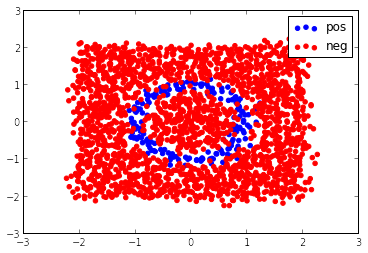

In [148]:
fig = plt.figure()
Xpos = X[Y==1]
Xneg = X[Y==0]
ax = fig.add_subplot(111)
ax.scatter(Xpos[:,0], Xpos[:,1], color='b', label='pos')
ax.scatter(Xneg[:,0], Xneg[:,1], color='r', label='neg')
plt.legend()
plt.show()

In [48]:
A = createEpsilonGraph(X, eps=np.inf)

In [442]:
pi = Y.sum() * 1.0 / Y.shape[0]
sparse = False
verbose = True
normalize = True

prms = ASI.Parameters(pi=pi, sparse=sparse, verbose=verbose)
sAS = ASI.shariAS(prms)

wnprms = ASI.WNParameters(normalize=normalize, pi=pi, sparse=sparse, verbose=verbose)
wnAS = ASI.weightedNeighborGraphAS(wnprms)

In [443]:
n_init = 1
init_pt = Y.nonzero()[0][np.random.choice(len(Y.nonzero()[0]), n_init, replace=False)]
init_labels = {p:1 for p in init_pt}

In [444]:
sAS.initialize(A, init_labels)
wnAS.initialize(A, init_labels)

Inverting I_A
Time for inverse: 0.556351900101
Done with the initialization.
Done with the initialization.


In [445]:
hits1 = [n_init]
hits2 = [n_init]
K = 10
for _ in range(K):
    idx1 = sAS.getNextMessage()
    sAS.setLabelCurrent(Y[idx1])
    hits1.append(hits1[-1]+Y[idx1])
    
    idx2 = wnAS.getNextMessage()
    wnAS.setLabelCurrent(Y[idx2])
    hits2.append(hits2[-1]+Y[idx2])

Iter: 1, Selected: 156, Hits: 2, Time: 0.012770
NNAS -- Iter: 1, Selected: 0, Hits: 2, Time: 0.000267
Iter: 2, Selected: 157, Hits: 3, Time: 0.007815
NNAS -- Iter: 2, Selected: 1, Hits: 3, Time: 0.000188
Iter: 3, Selected: 160, Hits: 4, Time: 0.004819
NNAS -- Iter: 3, Selected: 2, Hits: 4, Time: 0.000186
Iter: 4, Selected: 159, Hits: 5, Time: 0.007314
NNAS -- Iter: 4, Selected: 3, Hits: 5, Time: 0.000180
Iter: 5, Selected: 161, Hits: 6, Time: 0.004703
NNAS -- Iter: 5, Selected: 4, Hits: 6, Time: 0.000169
Iter: 6, Selected: 155, Hits: 7, Time: 0.006965
NNAS -- Iter: 6, Selected: 5, Hits: 7, Time: 0.000161
Iter: 7, Selected: 154, Hits: 8, Time: 0.004501
NNAS -- Iter: 7, Selected: 6, Hits: 8, Time: 0.000165
Iter: 8, Selected: 153, Hits: 9, Time: 0.006716
NNAS -- Iter: 8, Selected: 7, Hits: 9, Time: 0.000152
Iter: 9, Selected: 151, Hits: 10, Time: 0.004331
NNAS -- Iter: 9, Selected: 8, Hits: 10, Time: 0.000150
Iter: 10, Selected: 152, Hits: 11, Time: 0.006463
NNAS -- Iter: 10, Selected: 9,

In [10]:
X, Y = createSwissRolls()

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:526: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


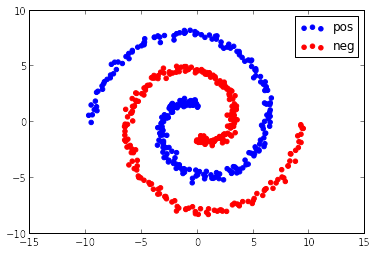

In [11]:
fig = plt.figure()
Xpos = X[Y==1]
Xneg = X[Y==0]
ax = fig.add_subplot(111)
ax.scatter(Xpos[:,0], Xpos[:,1], color='b', label='pos')
ax.scatter(Xneg[:,0], Xneg[:,1], color='r', label='neg')
plt.legend()
plt.show()

In [459]:
A = createEpsilonGraph(X, eps=np.inf, gamma=3)

In [478]:
pi = Y.sum() * 1.0 / Y.shape[0]
sparse = False
verbose = True
normalize = True
use_prior = False
prior_weight = 0.00001

prms = ASI.Parameters(pi=pi, sparse=sparse, verbose=verbose)
sAS = ASI.shariAS(prms)

wnprms = ASI.WNParameters(normalize=normalize, use_prior=use_prior, pi=pi, prior_weight=prior_weight, sparse=sparse, verbose=verbose)
wnAS = ASI.weightedNeighborGraphAS(wnprms)

In [496]:
# np_init = 1
# nn_init = 1
# n_init = np_init + nn_init
# initp_pt = Y.nonzero()[0][nr.choice(len(Y.nonzero()[0]), np_init, replace=False)]
# initn_pt = (Y==0).nonzero()[0][nr.choice(len(Y.nonzero()[0]), nn_init, replace=False)]
# init_labels = {p:1 for p in initp_pt}
# for p in initn_pt: init_labels[p] = 0
# init_labels = {22: 1, 275: 0}
init_labels = {113: 1, 423: 0}
n_init = 2
np_init = 1
nn_init = 1

In [480]:
sAS.initialize(A, init_labels)
wnAS.initialize(A, init_labels)

Inverting I_A
Time for inverse: 0.905338048935
Done with the initialization.
Done with the initialization.


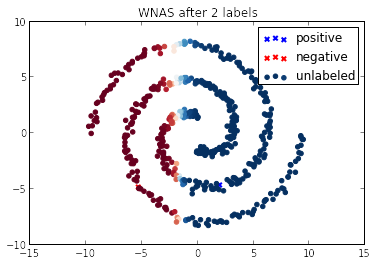

In [481]:
wnlabels = (np.where(wnAS.labels == 1, 1, 0) - np.where(wnAS.labels == 0, 1, 0))
wnasf = wnlabels.astype(float)
wnasf[wnAS.unlabeled_idxs] = (wnAS.f + 1)/2
plotData(X, None, wnasf, wnlabels, fid=1, title='WNAS after 2 labels')

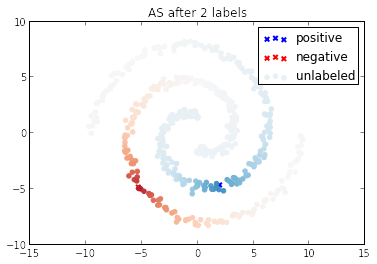

In [482]:
plotData(X, None, sAS.f, sAS.labels, fid=0, title='AS after 2 labels')

Iter: 1, Selected: 114, Hits: 2, Time: 0.008531
NNAS -- Iter: 1, Selected: 118, Hits: 2, Time: 0.000310
Iter: 2, Selected: 110, Hits: 3, Time: 0.003473
NNAS -- Iter: 2, Selected: 117, Hits: 3, Time: 0.000224
Iter: 3, Selected: 111, Hits: 4, Time: 0.004320
NNAS -- Iter: 3, Selected: 483, Hits: 3, Time: 0.000196
Iter: 4, Selected: 108, Hits: 5, Time: 0.003090
NNAS -- Iter: 4, Selected: 114, Hits: 4, Time: 0.000195
Iter: 5, Selected: 107, Hits: 6, Time: 0.003105
NNAS -- Iter: 5, Selected: 106, Hits: 5, Time: 0.000178
Iter: 6, Selected: 109, Hits: 7, Time: 0.003121
NNAS -- Iter: 6, Selected: 109, Hits: 6, Time: 0.000172
Iter: 7, Selected: 106, Hits: 8, Time: 0.003001
NNAS -- Iter: 7, Selected: 107, Hits: 7, Time: 0.000192
Iter: 8, Selected: 112, Hits: 9, Time: 0.018278
NNAS -- Iter: 8, Selected: 108, Hits: 8, Time: 0.000155
Iter: 9, Selected: 105, Hits: 10, Time: 0.002843
NNAS -- Iter: 9, Selected: 110, Hits: 9, Time: 0.000152
Iter: 10, Selected: 104, Hits: 11, Time: 0.008803
NNAS -- Iter:

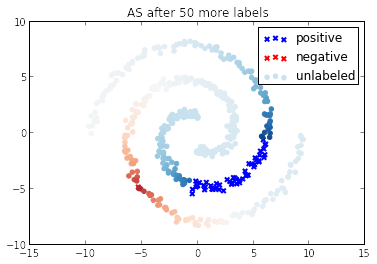

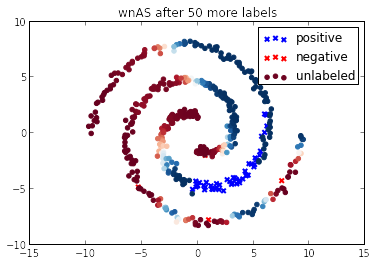

In [483]:
hits1 = [np_init]
hits2 = [np_init]
K = 50
for _ in range(K):
    idx1 = sAS.getNextMessage()
    sAS.setLabelCurrent(Y[idx1])
    hits1.append(hits1[-1]+Y[idx1])

    idx2 = wnAS.getNextMessage()
    wnAS.setLabelCurrent(Y[idx2])
    hits2.append(hits2[-1]+Y[idx2])

plotData(X, None, sAS.f, sAS.labels, fid=0, title='AS after 50 more labels')
wnlabels = np.where(wnAS.labels == 1, 1, 0) - np.where(wnAS.labels == 0, 1, 0)
wnasf = wnlabels.astype(float)
wnasf[wnAS.unlabeled_idxs] = (wnAS.f + 1)/2
plotData(X, None, wnasf, wnlabels, fid=1, title='wnAS after 50 more labels')

In [90]:
sAS.f[250:270]

array([ 0.49732,  0.49732,  0.49732,  0.49732,  0.49731,  0.49732,  0.49731,  0.49732,  0.49731,
        0.49731,  0.49731,  0.49731,  0.49732,  0.4973 ,  0.4973 ,  0.49731,  0.49727,  0.49728,
        0.49727,  0.49728])

In [289]:
init_labels

{22: 1, 275: 0}

In [410]:
wnAS.f

array([ 0.77642,  0.75734, -0.17685,  0.50861,  0.25802,  0.05487,  0.21857,  0.31051, -0.04384,
        0.29864, -0.751  ,  0.03546, -0.14276, -0.4485 , -0.9109 , -0.15414, -0.62587, -0.57496,
       -0.84077, -0.551  , -0.74883, -0.93745, -0.94259, -0.84735, -0.95247, -0.9278 , -0.96712,
       -0.95753, -0.97123, -0.99617, -0.98549, -0.99548, -0.99269, -0.97715, -0.99592, -0.9963 ,
       -0.99707, -0.98161, -0.98749, -0.98721, -0.99695, -0.99167, -0.99413, -0.99021, -0.99794,
       -0.99441, -0.99927, -0.99814, -0.99864, -0.99787, -0.9984 , -0.99674, -0.98367, -0.99515,
       -0.9929 , -0.98768, -0.99195, -0.97746, -0.9991 , -0.97733, -0.98898, -0.94485, -0.74239,
       -0.96499, -0.82281, -0.69868, -0.92854, -0.57444, -0.32678,  0.3099 , -0.04879,  0.59876,
        0.8544 ,  0.5528 ,  0.98588,  0.94357,  0.99711,  0.96783,  0.93239,  0.99627,  0.99982,
        0.99877,  0.99952,  0.99971,  0.99999,  0.99996,  0.99999,  0.99999,  1.     ,  1.     ,
        1.     ,  1.     ,  1.

In [436]:
self = wnAS
idx = wnAS.getNextMessage()
lbl = Y[idx]
# just in case, force lbl to be 0 or 1
lbl = -1 if lbl <= 0 else 1

# First, some book-keeping
# If setLabel is called without "firstMessage," then set start_point
if self.start_point is None:
  self.start_point = idx
if self.next_message != idx:
  self.uidx = np.nonzero(np.array(self.unlabeled_idxs)==idx)[0][0]

self.iter += 1
self.labels[idx] = lbl
self.unlabeled_idxs.remove(idx)

# Updating various parameters to calculate f
Sif = self.A[self.unlabeled_idxs, idx]
if self.params.sparse:
  Sif = matrix_squeeze(Sif.todense())

In [437]:
self.NN_avg_similarity = np.delete(self.NN_avg_similarity, self.uidx) + lbl*Sif

In [438]:
self.f = self.NN_avg_similarity.copy()

In [440]:
self.NN_abs_similarity = np.delete(self.NN_abs_similarity, self.uidx) + np.abs(Sif)
self.f /= self.NN_abs_similarity
self.f = np.nan_to_num(self.f)

In [495]:
hits1[-1]

52

In [431]:
ASI = reload(ASI)